# Exploring implementations of Diffuse Models

The goal is to understand how to use a pre-trained Diffuse Model to process audio.

## Intro to Diffuse Models

First we start by learning how to run an existing Diffuse Model.

Looking into this https://github.com/openai/guided-diffusion  
Check this as well https://github.com/openai/improved-diffusion the checkpoints might be useful.

Also explore running WaveNet: https://github.com/ibab/tensorflow-wavenet

### Idea to explore

Use the guided-diffusion model and train the upsampler on a giant library of audio spectograms.  
Figure out the requirements for the data (e.g. do I need a high+low res of the audio?).  

It's possible the unconditional unguided model works best here, since we have not seen spectrograms in the training data of the classifier.

### Temporary Goals
1. Get the sampler checkpoint running ✅
1. Get the upscaling running ☑️
    1. This requires figuring out how to get the spectrogram to the right size
    1. Use the vocoder to look at the result
    1. Maybe apply noise to the source to see what happens
1. Plan again

## Setup Environment

In [1]:
# Only run the first time (comment afterwards)
# TODO: Set this up as a git submodule
!mkdir thirdparty
!git clone https://github.com/openai/guided-diffusion.git thirdparty/guided-diffusion

mkdir: cannot create directory ‘thirdparty’: File exists
fatal: destination path 'thirdparty/guided-diffusion' already exists and is not an empty directory.


In [5]:
!pip install mpi4py
!pip install -e thirdparty/guided-diffusion/.

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Obtaining file:///notebooks/thirdparty/guided-diffusion
  Attempting uninstall: guided-diffusion
    Found existing installation: guided-diffusion 0.0.0
    Uninstalling guided-diffusion-0.0.0:
      Successfully uninstalled guided-diffusion-0.0.0
  Running setup.py develop for guided-diffusion


In [7]:
import numpy as np
import PIL.Image
from IPython.display import display

In [9]:
def show_images(images):
    [display(PIL.Image.fromarray(i)) for i in images]

In [11]:
%env SAMPLE_FLAGS=--batch_size 4 --num_samples 10 --timestep_respacing 250

env: SAMPLE_FLAGS=--batch_size 4 --num_samples 10 --timestep_respacing 250


## Image Sampling

### Sampling with guiding classifier (64x64)

In [ ]:
%env MODEL_FLAGS=--attention_resolutions 32,16,8 --class_cond True --diffusion_steps 1000 --dropout 0.1 --image_size 64 --learn_sigma True --noise_schedule cosine --num_channels 192 --num_head_channels 64 --num_res_blocks 3 --resblock_updown True --use_new_attention_order True --use_fp16 True --use_scale_shift_norm True
!python thirdparty/guided-diffusion/scripts/classifier_sample.py ${MODEL_FLAGS} --classifier_scale 1.0 --classifier_path models/64x64_classifier.pt --classifier_depth 4 --model_path models/64x64_diffusion.pt ${SAMPLE_FLAGS}

In [ ]:
!cp /tmp/openai-2022-05-27-19-56-32-118481/*.npz samples/

In [ ]:
samples_file = np.load("samples/samples_10x64x64x3.npz")
with samples_file as samples:
    show_images(samples["arr_0"])

### Image sample of base diffusion (64x64)

In [ ]:
%env MODEL_FLAGS=--attention_resolutions 32,16,8 --class_cond True --diffusion_steps 1000 --dropout 0.1 --image_size 64 --learn_sigma True --noise_schedule cosine --num_channels 192 --num_head_channels 64 --num_res_blocks 3 --resblock_updown True --use_new_attention_order True --use_fp16 True --use_scale_shift_norm True
!python thirdparty/guided-diffusion/scripts/image_sample.py ${MODEL_FLAGS} --model_path models/64x64_diffusion.pt ${SAMPLE_FLAGS}

In [ ]:
!cp /tmp/openai-2022-05-27-17-15-50-373768/*.npz ./samples/

In [ ]:
samples_file = np.load("samples/samples_100x64x64x3.npz")
with samples_file as samples:
    show_images(samples["arr_0"][1:11])

### Image sample (256x256)

In [ ]:
%env MODEL_FLAGS=--attention_resolutions 32,16,8 --class_cond True --diffusion_steps 1000 --image_size 256 --learn_sigma True --noise_schedule linear --num_channels 256 --num_head_channels 64 --num_res_blocks 2 --resblock_updown True --use_fp16 True --use_scale_shift_norm True
!python thirdparty/guided-diffusion/scripts/classifier_sample.py ${MODEL_FLAGS} --classifier_scale 1.0 --classifier_path models/256x256_classifier.pt --model_path models/256x256_diffusion.pt ${SAMPLE_FLAGS}

In [ ]:
!cp /tmp/openai-2022-05-27-17-57-23-275518/*.npz ./samples/

In [ ]:
samples_file = np.load("samples/samples_10x256x256x3.npz")
with samples_file as samples:
    show_images(samples["arr_0"])

## Upscalling

### 64 to 256

In [ ]:
%env MODEL_FLAGS=--attention_resolutions 32,16,8 --class_cond True --diffusion_steps 1000 --large_size 256  --small_size 64 --learn_sigma True --noise_schedule linear --num_channels 192 --num_heads 4 --num_res_blocks 2 --resblock_updown True --use_fp16 True --use_scale_shift_norm True
!python thirdparty/guided-diffusion/scripts/super_res_sample.py ${MODEL_FLAGS} --model_path models/64_256_upsampler.pt --base_samples samples/64_samples.npz ${SAMPLE_FLAGS}

In [ ]:
!cp /tmp/openai-2022-05-27-20-00-00-823605/*.npz samples/out_256_samples.npz

In [ ]:
samples_file = np.load("samples/64_samples.npz")
with samples_file as samples:
    show_images(samples["arr_0"])

In [ ]:
samples_file = np.load("samples/out_256_samples.npz")
with samples_file as samples:
    show_images(samples["arr_0"])

## Trying out with a spectrogram

The answer we're trying to answer is wether upscalling has any impact on the speech quality.

If not, what effect does it have? Is it a question of fine-tuning?
As a secondary but also important question, what happens when sampling from a model that was trained with audio data?

#### Notes

This is not expected to work out of the box, but we'll be training a custom model on spectograms next.

### TODO

- [ ] Create a 64_samples.npz with the Spectrogram in data (will need to figure out how to format it).  
- [ ] When running successfully, move the creation of new spectograms to a python file (based of the explore notebook).  
- [ ] If all works, create a new notebook with the training using larger audio dataset.

### Converting Spectrograms into Images

Spectrograms are generated/aggregated by a different notebook. Here we simply load them and format into our 64x64 image input.  

**TODO:** document the format of the spectrogram.

In [52]:
import torch
import numpy as np
from PIL import Image

In [53]:
def load_spectrogram(path, size=(64, 64)):
    spec_data = np.load(path) * 255.0 # needs to scale to rgb values
    spec_image = Image.fromarray(spec_data.astype("int32"))
    spec_image = spec_image.resize(size)
    return np.asarray(spec_image)

In [54]:
spectrogram = load_spectrogram("data/audio/synth_voice.wav.spec.npy")
spectrogram

array([[ 57,  77,  68, ...,  22,  26,  46],
       [ 64,  89,  76, ...,  34,  43,  64],
       [ 85, 109,  93, ...,  60,  61,  84],
       ...,
       [ 58,  79,  95, ...,  59,  62,  68],
       [ 55,  67,  84, ...,  53,  55,  67],
       [ 42,  53,  71, ...,  30,  30,  43]], dtype=int32)

In [17]:
spectrogram = np.expand_dims(spectrogram, axis=2)
spectrogram = np.concatenate((spectrogram, spectrogram, spectrogram), axis=2)
spectrogram

### Save Spectrograms into the input set (npz)

In [8]:
samples_file = np.load("samples/64_samples.npz")
with samples_file as samples:
    images = list(samples["arr_0"])

In [12]:
images[0].shape

(64, 64, 3)

In [18]:
np.savez("dataset.npz", np.array([spectrogram]), [0])

In [19]:
samples_file = np.load("dataset.npz")

In [20]:
len(samples_file["arr_0"]), len(samples_file["arr_1"])

(1, 1)

In [21]:
samples_file.close()

### Upscale and inspect the results

In [22]:
%env MODEL_FLAGS=--attention_resolutions 32,16,8 --class_cond True --diffusion_steps 1000 --large_size 256  --small_size 64 --learn_sigma True --noise_schedule linear --num_channels 192 --num_heads 4 --num_res_blocks 2 --resblock_updown True --use_fp16 True --use_scale_shift_norm True
!python thirdparty/guided-diffusion/scripts/super_res_sample.py ${MODEL_FLAGS} --model_path models/64_256_upsampler.pt --base_samples dataset.npz ${SAMPLE_FLAGS}

env: MODEL_FLAGS=--attention_resolutions 32,16,8 --class_cond True --diffusion_steps 1000 --large_size 256  --small_size 64 --learn_sigma True --noise_schedule linear --num_channels 192 --num_heads 4 --num_res_blocks 2 --resblock_updown True --use_fp16 True --use_scale_shift_norm True
Logging to /tmp/openai-2022-05-30-17-06-53-473412
creating model...
loading data...
creating samples...
/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:3784: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
created 4 samples
created 8 samples
created 12 samples
saving to /tmp/openai-2022-05-30-17-06-53-473412/samples_10x256x256x3.npz
sampling complete


In [26]:
!cp /tmp/openai-2022-05-30-17-06-53-473412/*.npz out_256_samples.npz

In [27]:
samples_file = np.load("dataset.npz")
with samples_file as samples:
    show_images(samples["arr_0"])

TypeError: Cannot handle this data type: (1, 1, 3), <i4

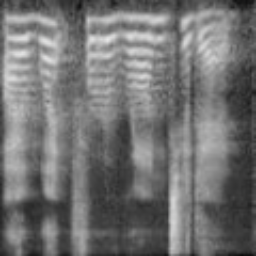

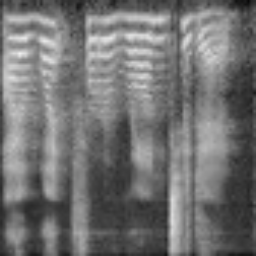

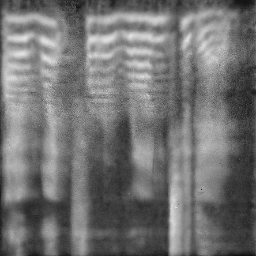

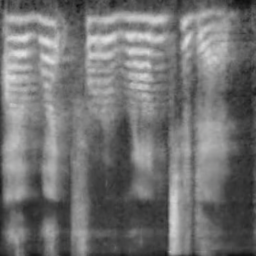

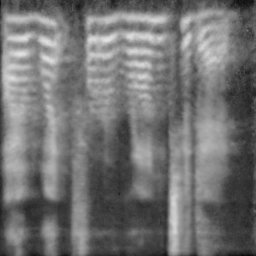

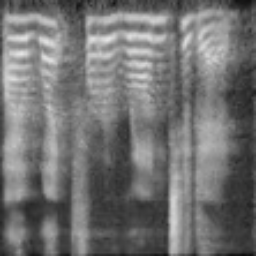

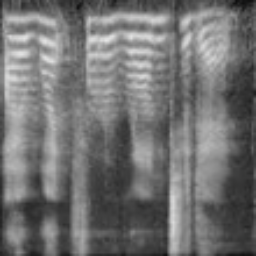

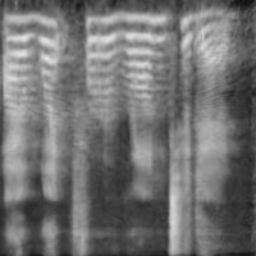

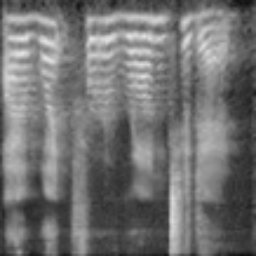

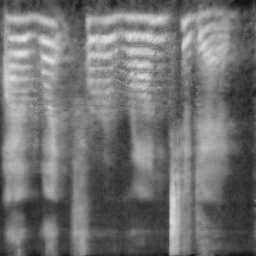

In [28]:
samples_file = np.load("out_256_samples.npz")
with samples_file as samples:
    show_images(samples["arr_0"])

### Vocoder pass

We have an upscaled spectrogram, let's convert it back into audio.

In [88]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

n_fft = 512 # 512 better for speech and 2048 (default) better for music, this should probably be a hyper-parameter

In [107]:
audio, sample_rate = librosa.load("data/audio/synth_voice.wav")
spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=n_fft, hop_length=n_fft // 2)
max_amplitude = np.max(spec)
normal_spec = librosa.power_to_db(spec, ref=np.max)

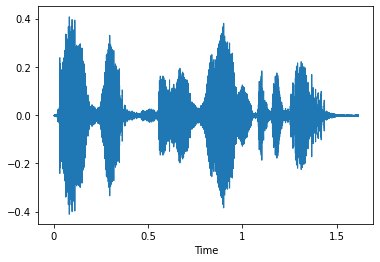

In [95]:
librosa.display.waveshow(audio)

In [100]:
Audio(audio, rate=sample_rate)

Text(0.5, 1.0, 'Spectogram')

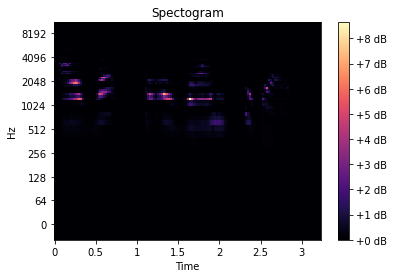

In [97]:
librosa.display.specshow(spec, sr=sample_rate, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectogram")

Text(0.5, 1.0, 'Spectogram 2')

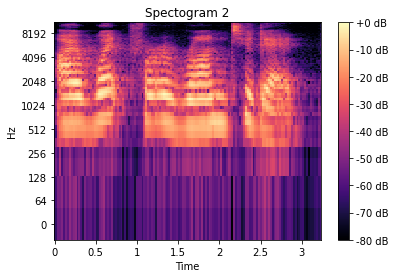

In [98]:
librosa.display.specshow(normal_spec, sr=sample_rate, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectogram 2")

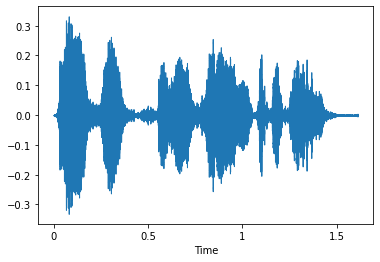

In [108]:
normal_audio = librosa.db_to_power(normal_spec, ref=max_amplitude)
normal_audio = librosa.feature.inverse.mel_to_audio(normal_audio, sr=sample_rate, n_fft=n_fft, hop_length=n_fft // 2)
librosa.display.waveshow(normal_audio)

In [101]:
Audio(normal_audio, rate=sample_rate)

/opt/conda/lib/python3.8/site-packages/IPython/lib/display.py:187: RuntimeWarning: invalid value encountered in true_divide
  scaled = data / normalization_factor * 32767


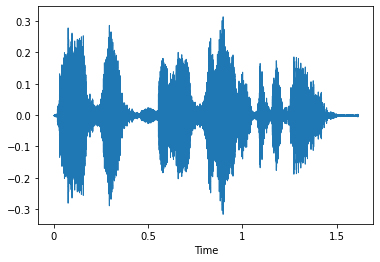

In [103]:
spec_audio = librosa.feature.inverse.mel_to_audio(spec, sr=sample_rate, n_fft=n_fft, hop_length=n_fft // 2)
librosa.display.waveshow(spec_audio)

In [104]:
Audio(spec_audio, rate=sample_rate)